<h1 align="center"><font size="7">Unsupervised ML: Clustering Project by Nikhil</font></h1>

In [1]:
import os
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

In [47]:
from sklearn.preprocessing import scale, StandardScaler, normalize
from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans , k_means

# Dataset obtained from kaggle: **Supermarket dataset for predictive marketing**

In [3]:
df = pd.read_csv('ECommerce_consumer_behaviour.csv')

In [4]:
df.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id,department,product_name
0,2425083,49125,1,2,18,NaN,17,1,0,13,pantry,baking ingredients
1,2425083,49125,1,2,18,NaN,91,2,0,16,dairy eggs,soy lactosefree
2,2425083,49125,1,2,18,NaN,36,3,0,16,dairy eggs,butter
3,2425083,49125,1,2,18,NaN,83,4,0,4,produce,fresh vegetables
4,2425083,49125,1,2,18,NaN,83,5,0,4,produce,fresh vegetables


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019501 entries, 0 to 2019500
Data columns (total 12 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   order_number            int64  
 3   order_dow               int64  
 4   order_hour_of_day       int64  
 5   days_since_prior_order  float64
 6   product_id              int64  
 7   add_to_cart_order       int64  
 8   reordered               int64  
 9   department_id           int64  
 10  department              object 
 11  product_name            object 
dtypes: float64(1), int64(9), object(2)
memory usage: 184.9+ MB


Supermarket consumer behaviour dataset consists of 2019501 Rows & 12 Columns:

    order_id – (A unique number to identity the order)
    user_id - (A unique number to identify the user)
    order_number – (Number of the order)
    order_dow – (Day of the Week the order was made)
    order_hour_of_day – (Time of the order)
    days_since_prior_order - (History of the order)
    product_id – (Id of the product)
    add_to_cart_order – (Number of items added to cart)
    reordered – (If the reorder took place)
    department_id - (Unique number allocated to each department)
    department – (Names of the departments)
    product_name – (Name of the products)


# Contents

1) Explorative Data Analysis
2) KMeans Cluster Analysis
3) Conclusion

# 1) Explorative Data Analysis

In [6]:
df.isna().sum()

order_id                       0
user_id                        0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    124342
product_id                     0
add_to_cart_order              0
reordered                      0
department_id                  0
department                     0
product_name                   0
dtype: int64

In [7]:
#fill days since prior order with 0 as there cannot be negative values
df.fillna(0, inplace=True)

### Busiest times of the day

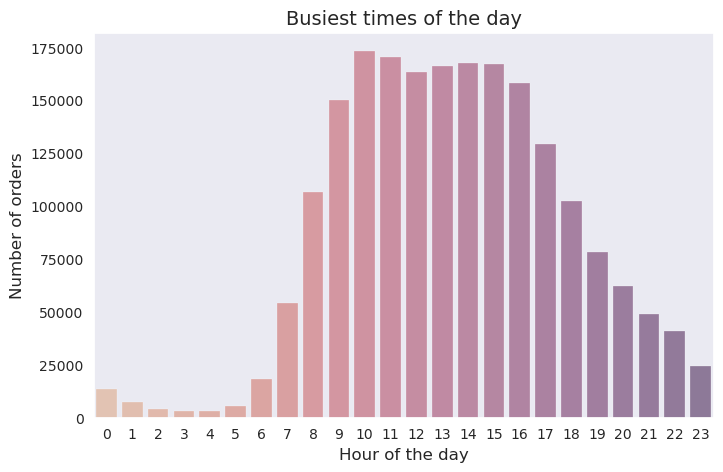

In [8]:
# df['order_hour_of_day'].value_counts()
plt.figure(figsize = (8,5))
# sns.set_style("ticks")
sns.set_style('dark')
sns.set_palette("rocket_r")
sns.countplot(data=df, x=df['order_hour_of_day'], palette = 'flare', alpha=0.6)
plt.title("Busiest times of the day", fontsize=14)
plt.xlabel("Hour of the day", fontsize=12)
plt.ylabel("Number of orders", fontsize=12)
plt.show()

### Popular departments

In [9]:
departments = df['department'].value_counts()

departments_df = pd.DataFrame(departments).reset_index()

departments_df.columns = ['Department', 'Order Count']

top_departments = departments_df.sort_values(by='Order Count', ascending=False).head()

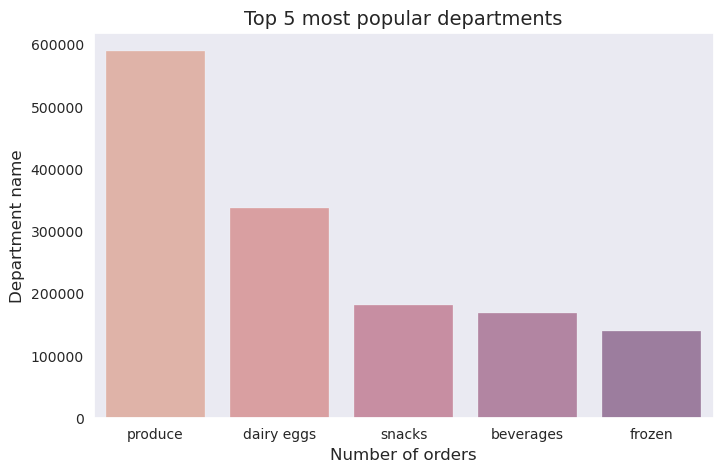

In [11]:
plt.figure(figsize = (8,5))
sns.set_style('dark')
sns.set_palette("rocket_r")
# sns.set_style("ticks")
sns.barplot(data=top_departments, x="Department", y="Order Count", palette = 'flare', alpha=0.6)
plt.title("Top 5 most popular departments", fontsize=14)
plt.xlabel("Number of orders", fontsize=12)
plt.ylabel("Department name", fontsize=12)
plt.show()

### Popular Products

In [12]:
products = df['product_name'].value_counts()
products_df = pd.DataFrame(products).reset_index()
products_df.columns = ['Product', 'Order Count']
top_products = products_df.sort_values(by='Order Count', ascending=False).head()

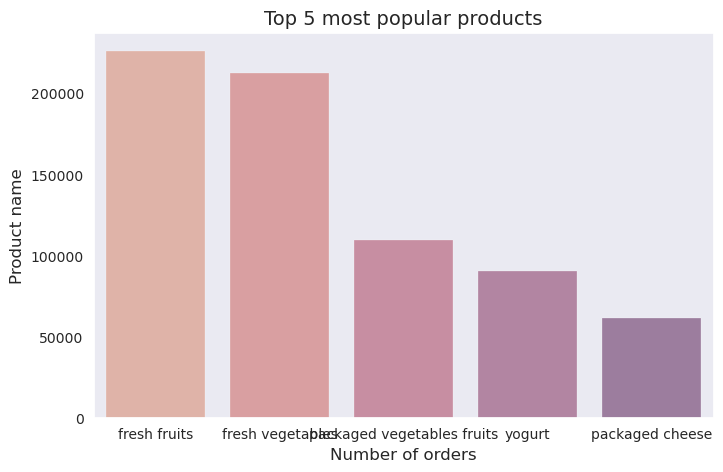

In [13]:
plt.figure(figsize = (8,5))
# sns.set_style("ticks")
sns.set_style('dark')
sns.set_palette("rocket_r")
sns.barplot(data=top_products, x="Product", y="Order Count", palette = 'flare', alpha=0.6)
plt.title("Top 5 most popular products", fontsize=14)
plt.xlabel("Number of orders", fontsize=12)
plt.ylabel("Product name", fontsize=12)
plt.show()

In [14]:
#drop columns that have no signal
df_copy = df.copy()
df.drop(['order_id', 'user_id', 'order_number','product_id', 'department_id', 'department'], axis=1, inplace=True)

In [15]:
df.head()

,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,product_name
0,2,18,0.0,1,0,baking ingredients
1,2,18,0.0,2,0,soy lactosefree
2,2,18,0.0,3,0,butter
3,2,18,0.0,4,0,fresh vegetables
4,2,18,0.0,5,0,fresh vegetables


# 2) KMeans Cluster Analysis

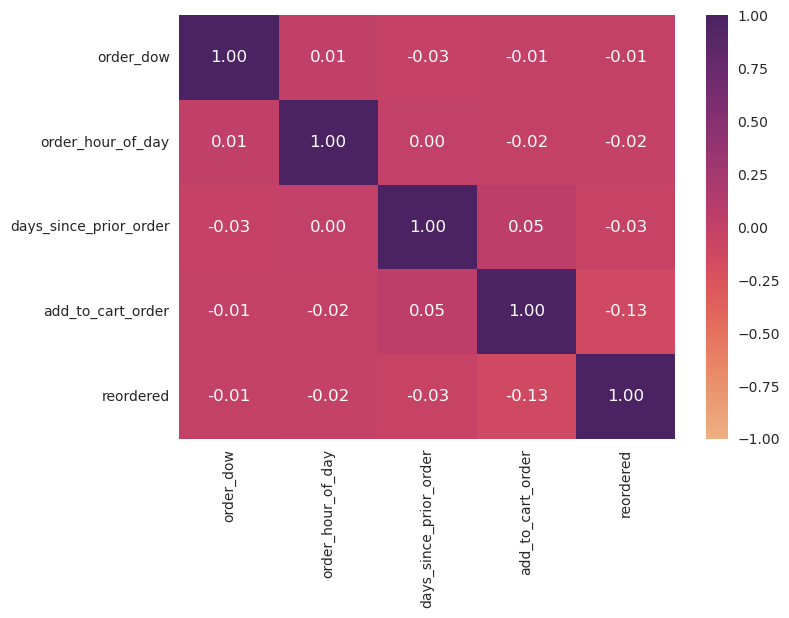

In [16]:
#check for any correlations in the dataset
sns.heatmap(df.corr(), 
            annot=True,
            vmin=-1,
            vmax=1,
            cmap='flare',
            fmt='.2f')
plt.show()

## Scaling the data

In [17]:
#scale the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.iloc[:, :-1])

In [18]:
df_scaled = pd.DataFrame(df_scaled)
df_scaled.head()

,0,1,2,3,4
0,-0.351198,1.075339,-1.172731,-1.029806,-1.198956
1,-0.351198,1.075339,-1.172731,-0.889947,-1.198956
2,-0.351198,1.075339,-1.172731,-0.750088,-1.198956
3,-0.351198,1.075339,-1.172731,-0.610229,-1.198956
4,-0.351198,1.075339,-1.172731,-0.470370,-1.198956


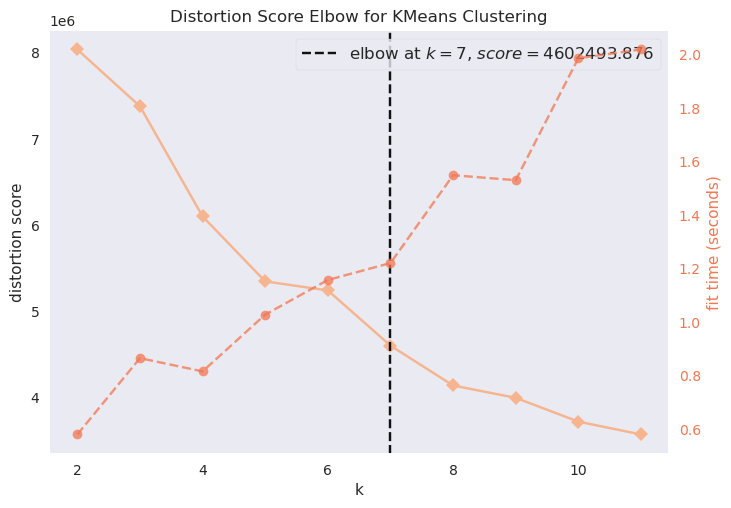

In [19]:
#check for number of optimal clusters
model = KMeans(n_init='auto')
visualiser = KElbowVisualizer(model, k=(2,12))
visualiser.fit(df_scaled)        
visualiser.show();

In [20]:
#fit the model with 7 clusters

kmeans_mod = KMeans(n_clusters=7, n_init='auto')
kmeans_mod.fit(df_scaled)

KMeans(n_clusters=7, n_init='auto')

In [21]:
df['cluster'] = kmeans_mod.labels_
df.head()

,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,reordered,product_name,cluster
0,2,18,0.0,1,0,baking ingredients,1
1,2,18,0.0,2,0,soy lactosefree,1
2,2,18,0.0,3,0,butter,1
3,2,18,0.0,4,0,fresh vegetables,1
4,2,18,0.0,5,0,fresh vegetables,1


In [22]:
df['cluster'].value_counts()

2    356960
4    315506
0    313616
6    299882
5    297993
1    280846
3    154698
Name: cluster, dtype: int64

## Gridsearch

In [22]:
grid_pca = PCA()
grid_kmeans = KMeans(init ='k-means++')
pipe = Pipeline([('gridpca', grid_pca),('gridkmeans', grid_kmeans)])

param_grid = {
    "gridpca__n_components": [4,5],
    "gridkmeans__n_clusters": [5,6,7]
}
gridsearch = GridSearchCV(pipe, param_grid, n_jobs=2)

gridsearch = gridsearch.fit(df_scaled)

gridsearch.best_estimator_

/home/nikhil/miniconda3/envs/pyenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/nikhil/miniconda3/envs/pyenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/nikhil/miniconda3/envs/pyenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/nikhil/miniconda3/envs/pyenv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

Pipeline(steps=[('gridpca', PCA(n_components=4)),
                ('gridkmeans', KMeans(n_clusters=7))])

## KMeans(7) with PCA(4)

From the gridsearch it is suggested to use 7 number of cluster and PCA with 4 components.
We execute this and try to see how the clustering works.

In [23]:
pca1 = PCA(n_components=4)
df_pca1 = pca1.fit(df_scaled).transform(df_scaled)

In [24]:
km1 = KMeans(n_clusters=7,init ='k-means++')
km1 = km1.fit(df_pca1)

In [25]:
kmpca1_label = km1.predict(df_pca1)
kmpca1_label = pd.DataFrame(data=kmpca1_label, columns=['kmpca1_label'])

In [26]:
df_kmpca1 = pd.DataFrame(df_pca1, columns =['Component 1', 'Component 2','Component 3', 'Component 4'])
df_kmpca1.head()

,Component 1,Component 2,Component 3,Component 4
0,-0.278378,-0.999085,-0.730310,-1.357894
1,-0.184500,-1.003332,-0.703474,-1.376730
2,-0.090622,-1.007578,-0.676637,-1.395566
3,0.003255,-1.011824,-0.649800,-1.414402
4,0.097133,-1.016071,-0.622963,-1.433239


In [27]:
pca1.components_

array([[-0.06619024,  0.01639269,  0.34817902,  0.67123149, -0.65082239],
       [-0.73982057, -0.46315189,  0.41531829, -0.0303622 ,  0.25444983],
       [ 0.30327927, -0.85595786, -0.36859947,  0.19188472, -0.05169631],
       [ 0.59366011, -0.15571567,  0.75202024, -0.13468001,  0.19911592]])

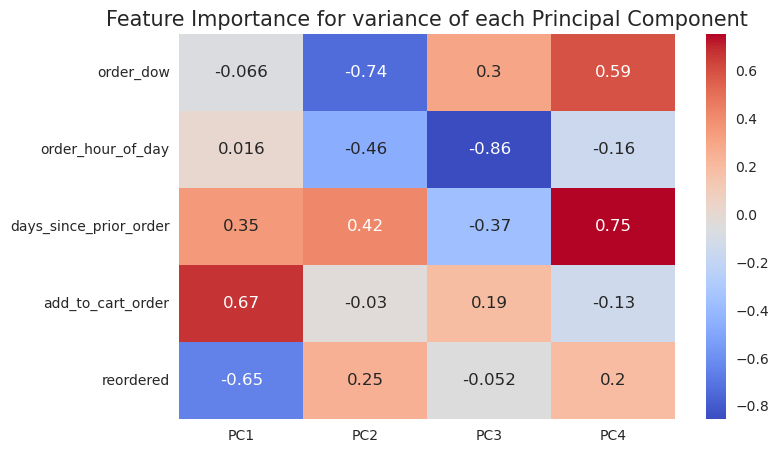

In [28]:
# feature importance for each component
figure = plt.figure(figsize=(8, 5))

sns.heatmap(pd.DataFrame(pca1.components_).transpose(),
            annot=True,
            xticklabels=['PC1', 'PC2', 'PC3', 'PC4'],
            yticklabels=df.iloc[:,:-2].columns,
            cmap='coolwarm')

plt.title('Feature Importance for variance of each Principal Component', fontsize=15)
plt.show()

- PC1 are mostly customers that reorder and order a large number of items at each order
- PC2 are influenced mostly by the day of the week
- PC3 are influenced by the hour of the day
- PC4 are influenced by the days since prior order

## Plot the PCA data with the Clusters from the Kmeans

In [40]:
# combine data for plotting
df.reset_index(drop=True, inplace=True)
df_kmpca1.reset_index(drop=True, inplace=True)
plot_data = pd.concat([df_kmpca1, df['cluster']], axis=1)

In [45]:
# RUNNING PCA TO VISUALIZE DATA
X_r = df_pca1
y_num = kmpca1_label['kmpca1_label']

target_names = ["Cluster 0","Cluster 1","Cluster 2", "Cluster 3","Cluster 4"]

<Figure size 800x550 with 0 Axes>

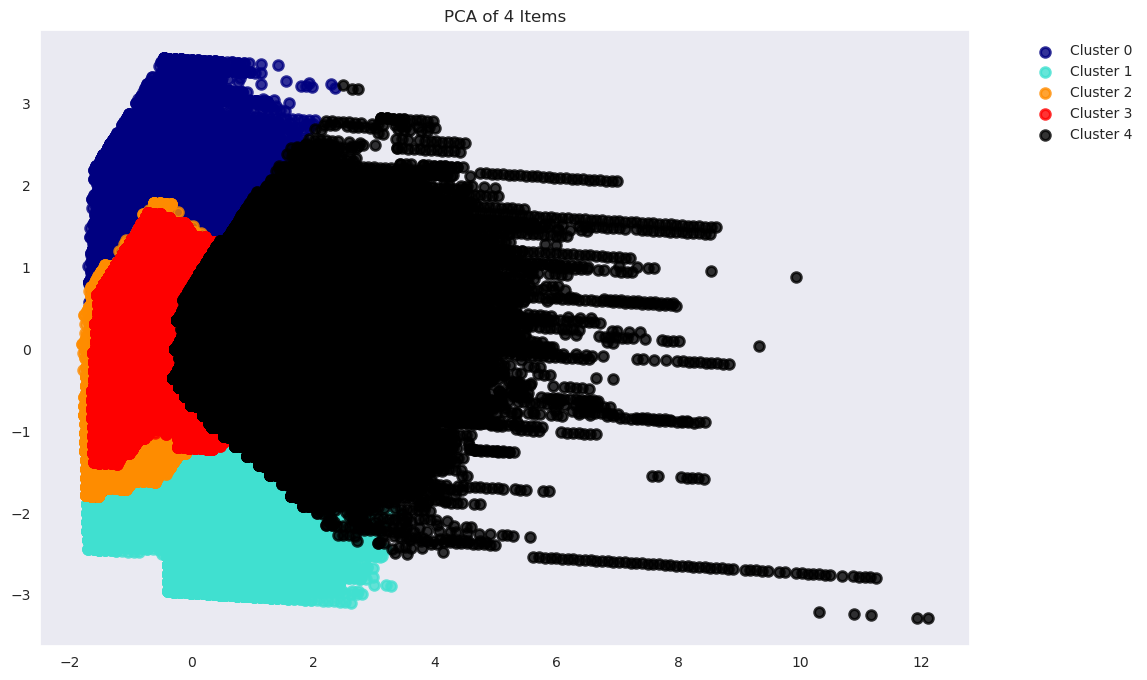

In [46]:
# PLOTTING DATA POINTS
plt.figure()
plt.figure(figsize=(12,8))
colors = ['navy', 'turquoise', 'darkorange', 'red', 'black']
lw = 2


for color, i, target_name in zip(colors, [0, 1, 2, 3,4], target_names):
    plt.scatter(X_r[y_num == i, 0], X_r[y_num == i, 1], color=color, alpha=.8, lw=lw,label=target_name)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.6)   
plt.title('PCA of 4 Items')
plt.show()

# 3) Conclusion

From the two clustering methods, it is clear that the KMeans(7) with PCA(4) is the best method. So using KMeans(7) with PCA(4) the 7 clusters are classified with best accuracy as in the actual classification.